# Quasi-deuteron model

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ January 24, 2022

Using method from SRC paper to analyze the quasi-deuteron model and the Levinger constant. This notebook is based on this paper: A. J. Tropiano, S. K. Bogner, R. J. Furnstahl, and M. A. Hisham, (2022), [arXiv:2205.06711 [nucl-th]](https://arxiv.org/abs/2205.06711), building on the methodology of A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __104__, 034311 (2021)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.104.034311).

_Last update:_ July 29, 2022

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, xkcd_colors, label_kvnn, label_lambda, label_nucleus,
)
from scripts.fourier_transform import hankel_transformation_k2r
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_vector
)
from scripts.levinger_constant import compute_L
from scripts.momentum_distributions import MomentumDistribution
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import convert_number_to_string, replace_periods
from scripts.wave_function import wave_function

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/quasideuteron/'

# Directory for experimental L values
exp_directory = '../data/exp/'

## Plotting functions

In [5]:
def pn_over_d_ratio(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='Gogny', x_limits=(0,5),
        y_limits=(0,15), xlabel_size=16, ylabel_size=16, kvnn_label=True,
        save=False):
    """
    Plots ratios of the proton-neutron pair momentum distribution over the
    deuteron momentum distribution as a function of relative momentum q
    [fm^-1] (where the C.o.M. momentum Q is integrated out). The Levinger
    constant L is indicated by plateaus at high relative momentum scaled by
    NZ/A.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple, optional
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    kvnn_label : bool, optional
        Option to label the potential on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Set-up momentum arrays --- #
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, x_limits[-1], 0.05
    q_array = np.arange(q_min, q_max+q_step, q_step)
    ntot_q = len(q_array)
    
    # Set-up meshgrids corresponding to q_i and Q_j
    q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up meshgrid for Q integration (Q_j^2 dQ_j)
    _, dQ_grid = np.meshgrid(q_array, Q_array**2*Q_weights, indexing='ij')
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Plot initial features --- #
    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.axhline(y=L_mean, label="L", alpha=0.6, color='xkcd:gray', 
               linestyle='dashdot')
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    alpha=0.3, color='xkcd:gray')

    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)

    n_d_func = md.get_deuteron_momentum_distribution(generator, lamb,
                                                     interpolate=True)
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
    
    # Loop over nuclei and calculate pn distribution
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
        A = Z + N
    
        n_pn_func = md.get_pair_momentum_distribution(
            'pn', nucleus_name, density, channels, generator, lamb,
            interpolate=True
        )

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum,
        # where the factor of 2 is for pn + np
        n_pn_array_2d = 2*n_pn_func.ev(q_grid, Q_grid)

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_grid*n_pn_array_2d, axis=-1)
    
        # Calculate pn/d ratio
        ratio_array = A/(N*Z) * n_pn_array / n_d_array

        # --- Set data labels --- #
        curve_label = label_nucleus(nucleus_name)
        curve_color = xkcd_colors(i+1)  # Skip black

        # --- Plot --- #
        ax.plot(q_array, ratio_array, color=curve_color, label=curve_label,
                linewidth=2.0)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$\frac{A}{NZ} \frac{n_{pn}^A(q)}{n_{p}^d(q)}$",
                  fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=12, frameon=False, ncol=2)

    # --- Additional labels --- #
    if kvnn_label:  # Label the potential
        ax.add_artist(
            AnchoredText(label_kvnn(kvnn), loc='lower right',
                         prop=dict(size=15))
        )
        
    # --- Save file --- #
    if save:
        file_name = f'pn_over_d_ratio_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [6]:
def levinger_constant_experiment(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='Gogny', x_limits=(5e0,3e2),
        y_limits=(0,10), xlabel_size=16, ylabel_size=16, save=False):
    """
    Plots average Levinger constant values L associated with the ratio of
    pn/d momentum distributions comparing to experimental extractions.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn : int
        This number specifies the potential.
    channels : tuple, optional
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [unitless].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Set-up momentum arrays --- #
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
    
    # Average over two different ranges of q values
    q_min_1, q_max_1, q_step_1 = 4.0, 5.0, 0.1  # 4-5 fm^-1
    q_array_1 = np.arange(q_min_1, q_max_1+q_step_1, q_step_1)
    q_min_2, q_max_2, q_step_2 = 2.5, 3.4, 0.05  # 2.5-3.4 fm^-1
    q_array_2 = np.arange(q_min_2, q_max_2+q_step_2, q_step_2)
    
    # Set-up meshgrids corresponding to q_i and Q_j
    q_grid_1, Q_grid_1 = np.meshgrid(q_array_1, Q_array, indexing='ij')
    q_grid_2, Q_grid_2 = np.meshgrid(q_array_2, Q_array, indexing='ij')
    
    # Set-up meshgrid for Q integration (Q_j^2 dQ_j)
    _, dQ_grid_1 = np.meshgrid(q_array_1, Q_array**2*Q_weights, indexing='ij')
    _, dQ_grid_2 = np.meshgrid(q_array_2, Q_array**2*Q_weights, indexing='ij')

    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # --- Plot initial features --- #
    # Add experimental values to plot
    data_ahr = np.loadtxt(exp_directory
                          + 'Ahrens_L_Li7_Be9_C12_O16_Al27_Ca40.txt')
    A_ahr_array = data_ahr[:, 0]
    L_ahr_array = data_ahr[:, 1]
    L_errors_ahr_array = np.array((data_ahr[:, 2], data_ahr[:, 3]))
    
    data_sti = np.loadtxt(
        exp_directory + 'Stibunov_L_C12_Al27_Ti48_Cu63_Ag107_Sn118_Pb208.txt'
    )
    A_sti_array = data_sti[:, 0]
    L_sti_array = data_sti[:, 1]
    L_errors_sti_array = np.array((data_sti[:, 2], data_sti[:, 3]))
    
    data_lep = np.loadtxt(exp_directory
                          + 'Lepretre_L_Sn118_Ce140_Ta181_Pb208_U238.txt')
    A_lep_array = data_lep[:, 0]
    L_lep_array = data_lep[:, 1]
    L_errors_lep_array = np.array((data_lep[:, 2], data_lep[:, 3]))
    
    ax.errorbar(
        A_ahr_array, L_ahr_array, yerr=L_errors_ahr_array, color='xkcd:red',
        label='Ahrens', linestyle='', marker='^', markersize=6
    )
    ax.errorbar(
        A_sti_array, L_sti_array, yerr=L_errors_sti_array, color='xkcd:green',
        label='Stibunov', linestyle='', marker='d', markersize=6
    )
    ax.errorbar(
        A_lep_array, L_lep_array, yerr=L_errors_lep_array, color='xkcd:blue',
        label='Lepretre', linestyle='', marker='s', markersize=6
    )
    
    # --- Get data --- #
    # Initialize arrays for A and both values of L
    A_array = np.zeros(len(nuclei))
    L_array_2d = np.zeros((len(nuclei),2))
    
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)

    n_d_func = md.get_deuteron_momentum_distribution(generator, lamb,
                                                     interpolate=True)
    
    # Calculate deuteron momentum distribution on both q arrays
    n_d_array_1 = n_d_func(q_array_1)
    n_d_array_2 = n_d_func(q_array_2)
        
    # Loop over nuclei and calculate L for both q arrays
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
        A = Z + N
        A_array[i] = A
    
        n_pn_func = md.get_pair_momentum_distribution(
            'pn', nucleus_name, density, channels, generator, lamb,
            interpolate=True
        )

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum,
        # where the factor of 2 is for pn + np
        n_pn_array_2d_1 = 2*n_pn_func.ev(q_grid_1, Q_grid_1)
        n_pn_array_2d_2 = 2*n_pn_func.ev(q_grid_2, Q_grid_2)

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array_1 = factor * np.sum(dQ_grid_1*n_pn_array_2d_1, axis=-1)
        n_pn_array_2 = factor * np.sum(dQ_grid_2*n_pn_array_2d_2, axis=-1)
    
        # Calculate L for both q arrays
        L_array_2d[i,0] = compute_L(A, Z, N, n_pn_array_1, n_d_array_1)
        L_array_2d[i,1] = compute_L(A, Z, N, n_pn_array_2, n_d_array_2)
        
    # Take average of L values as central value and use minimum and maximum
    # as errorbars
    L_array = np.mean(L_array_2d, axis=-1)
    L_errors_array = abs(L_array_2d[:,0] - L_array_2d[:,1]) / 2

    # --- Plot --- #
    # Plot all your values at the same time (same markers and color)
    ax.errorbar(
        A_array, L_array, yerr=L_errors_array, color='xkcd:black',
        label=label_kvnn(kvnn), linestyle='', marker='o', markersize=4
    )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel("L", fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=13, frameon=False, ncol=2)

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    if save:
        file_name = f'levinger_constant_experiment_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [7]:
def levinger_constant_multiple_kvnns(
        nuclei, kvnns, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='Gogny', x_limits=(5e0,3e2),
        y_limits=(0,8), xlabel_size=16, ylabel_size=16, save=False):
    """
    Plots average Levinger constant values L associated with the ratio of
    pn/d momentum distributions comparing different potentials. 

    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnns : tuple
        Numbers that specify a set of potentials.
    channels : tuple, optional
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [unitless].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Set-up momentum arrays --- #
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
    
    # Average over relative momentum values 2.5-3.4 fm^-1
    q_min, q_max, q_step = 2.5, 3.4, 0.05
    q_array = np.arange(q_min, q_max+q_step, q_step)
    ntot_q = len(q_array)
    
    # Set-up meshgrids corresponding to q_i and Q_j
    q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up meshgrid for Q integration (Q_j^2 dQ_j)
    _, dQ_grid = np.meshgrid(q_array, Q_array**2*Q_weights, indexing='ij')
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # --- Get data --- #
    # Loop over kvnn
    for i, kvnn in enumerate(kvnns):
    
        # Initialize arrays for A and L
        A_array = np.zeros(len(nuclei))
        L_array = np.zeros(len(nuclei))
    
        # Initialize momentum distribution object
        md = MomentumDistribution(kvnn, kmax, kmid, ntot)

        n_d_func = md.get_deuteron_momentum_distribution(generator, lamb,
                                                         interpolate=True)
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_array)
        
        # Loop over nuclei and calculate L
        for j, nucleus in enumerate(nuclei):
        
            # Unpack nucleus information
            nucleus_name, Z, N = nucleus
            A = Z + N
            A_array[j] = A
    
            n_pn_func = md.get_pair_momentum_distribution(
                'pn', nucleus_name, density, channels, generator, lamb,
                interpolate=True
            )

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum,
            # where the factor of 2 is for pn + np
            n_pn_array_2d = 2*n_pn_func.ev(q_grid, Q_grid)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_grid*n_pn_array_2d, axis=-1)
    
            # Calculate L for both q arrays
            L_array[j] = compute_L(A, Z, N, n_pn_array, n_d_array)
                              
        # --- Set data labels --- #
        marker_label = label_kvnn(kvnn)  # Label potential in legend
        marker_color = xkcd_colors(i)
        # Set marker style
        if i == 0:
            marker_style = 's'
        elif i == 1:
            marker_style = 'o'
        elif i == 2:
            marker_style = 'd'
        elif i == 3:
            marker_style = '^'
        elif i == 4:
            marker_style = 'v'
        elif i == 5:
            marker_style = 'p'
        else:
            raise RuntimeError("Too many kvnns.")

        # --- Plot --- #
        ax.plot(A_array, L_array, color=marker_color, label=marker_label,
                linestyle='', marker=marker_style, markersize=4)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel("L", fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=9, frameon=False, ncol=2)

    # --- Additional labels --- #
    # Set anchored texts

    # --- Save file --- #
    if save:
        file_name = 'levinger_constant_multiple_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [8]:
def deuteron_scale_dependence(
        kvnn_soft, kvnn_hard, lambdas, kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', x_limits=(0, 6), y_limits=(1e-6, 1e3),
        xlabel_size=16, ylabel_size=16, save=False):
    """
    Plots deuteron momentum distributions comparing a hard potential, which
    is SRG-evolved at several \lambda values, to a softer potential.

    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambdas : tuple
        SRG evolution parameters \lambda [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm^3].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
        
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Plot initial features --- #
    channel = '3S1'  # 3S1-3D1 for deuteron
    
    # Initialize soft potential and get its momentum mesh
    potential_soft = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    # The momentum mesh should be the same between both potentials
    q_array, q_weights = potential_soft.load_mesh()

    H_soft = potential_soft.load_hamiltonian()
    
    # Get deuteron wave function [unitless]
    psi_d_soft_weights = wave_function(H_soft)
    
    # Convert to fm^3/2
    psi_d_soft = unattach_weights_from_vector(
        q_array, q_weights, psi_d_soft_weights, coupled_channel=True
    )
    
    # Deuteron momentum distribution [fm^3]
    n_d_soft = psi_d_soft[:ntot]**2 + psi_d_soft[ntot:]**2
    
    # Repeat the above but for the hard potential
    potential_hard = Potential(kvnn_hard, channel, kmax, kmid, ntot)

    H_hard_initial = potential_hard.load_hamiltonian()
    
    psi_d_hard_weights = wave_function(H_hard_initial)
    
    psi_d_hard = unattach_weights_from_vector(
        q_array, q_weights, psi_d_hard_weights, coupled_channel=True
    )
    
    n_d_hard = psi_d_hard[:ntot]**2 + psi_d_hard[ntot:]**2
    
    # Plot initial momentum distributions of both potentials
    ax.semilogy(q_array, n_d_hard, color='xkcd:blue',
                label=label_kvnn(kvnn_hard), linestyle='solid', linewidth=2.0)
    ax.semilogy(q_array, n_d_soft, color='xkcd:red',
                label=label_kvnn(kvnn_soft), linestyle='solid', linewidth=2.0)

    # --- Get data --- #
    # Loop over \lambda and add to plot
    for i, lamb in enumerate(lambdas):
        
        # Get evolved Hamiltonian for hard potential
        H_hard_evolved = potential_hard.load_hamiltonian('srg', generator,
                                                         lamb)

        # Get SRG transformation connecting the two potentials
        U_matrix = get_transformation(H_hard_initial, H_hard_evolved)

        # SRG-evolved deuteron wave function [unitless]
        psi_d_hard_weights = wave_function(H_hard_initial, U_matrix=U_matrix)
        
        # Convert to fm^3/2
        psi_d_hard = unattach_weights_from_vector(
            q_array, q_weights, psi_d_hard_weights, coupled_channel=True
        )
    
        # SRG-evolved deuteron momentum distribution
        n_d_hard = psi_d_hard[:ntot]**2 + psi_d_hard[ntot:]**2

        # --- Set data labels --- #
        curve_alpha = 0.8 - i*0.2  # Vary transparency with \lambda

        # --- Plot --- #
        ax.plot(q_array, n_d_hard, alpha=curve_alpha, color='xkcd:blue',
                label=label_lambda(lamb), linestyle='dashed', linewidth=2.0)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$n_d(q)$ [fm" + r"$^3$" + "]", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=11, frameon=False)

    # --- Additional labels --- #
    # Set anchored texts

    if save:
        file_name = (f'deuteron_scale_dependence_kvnn_soft_{kvnn_soft}'
                     f'_kvnn_hard_{kvnn_hard}_lambdas')
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name += f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [9]:
def inverse_srg(
        kvnn_soft, kvnn_hard, channel, generator, lambda_m_values, kmax, kmid,
        ntot):
    """
    Apply inverse SRG transformations to a soft potential to make it harder.
    
    Parameters
    ----------
    kvnn_soft : int
        This number specifies the soft potential.
    kvnn_hard : int
        This number specifies the hard potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_m_values : tuple
        SRG \lambda evolution values [fm^-1].
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    
    Returns
    -------
    H_list : list
        List of Hamiltonians [MeV], which are 2-D ndarrays.
        
    """
    
    # Initialize both the soft and hard potential
    potential_soft = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    potential_hard = Potential(kvnn_hard, channel, kmax, kmid, ntot)

    # Get initial Hamiltonians for the soft and hard potentials (MeV)
    H_soft_initial = potential_soft.load_hamiltonian()
    H_hard_initial = potential_hard.load_hamiltonian()
    
    # Initialize list of Hamiltonians
    H_list = [H_hard_initial, H_soft_initial]

    # Loop over \lambda values
    for lamb_m in lambda_m_values:

        # Get the SRG-evolved hard potential (MeV)
        H_hard_evolved = potential_hard.load_hamiltonian('srg', 'Wegner',
                                                         lamb_m)

        # Construct SRG transformation (unitless)
        U_matrix = get_transformation(H_hard_initial, H_hard_evolved)
    
        # Apply inverse transformations to soft potential
        H_soft_evolved = U_matrix.T @ H_soft_initial @ U_matrix
        
        # Append inverse-evolved Hamiltonian [MeV] to list
        H_list.append(H_soft_evolved)

    # Return list of Hamiltonians
    return H_list

In [10]:
def deuteron_scale_dependence_inv_r(
        kvnn_soft, kvnn_hard, lambda_m_values, kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', x_limits=(0,3), y_limits=(-0.15,0.5),
        xlabel_size=16, ylabel_size=16, hamiltonian_label=True, save=False):
    """
    Plots the deuteron wave function [fm^-3/2] in coordinate space comparing
    a hard and soft potential, where the soft potential is inverse-SRG
    evolved at several \lambda_m values.

    Parameters
    ----------
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_m_values : tuple
        SRG evolution parameters \lambda [fm^-1] for inverse-SRG
        transformations.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    x_limits : tuple, optional
        Limits for the x-axis [fm].
    y_limits : tuple, optional
        Limits for the y-axis [fm^-3/2].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    hamiltonian_label : bool, optional
        Option to label the inverse-transformed Hamiltonian on the figure as
        an anchored text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))

    # --- Plot initial features --- #
    # Add horizontal line at psi_d = 0
    ax.axhline(0.0, alpha=0.4, color='gray')
    
    # --- Get data --- #
    # 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Hamiltonians ordered as follows: H_hard, H_soft, H_soft(\lambda_m), ...
    H_list = inverse_srg(kvnn_soft, kvnn_hard, channel, generator,
                         lambda_m_values, kmax, kmid, ntot)
    
    # Get momenta and weights (doesn't matter which kvnn or channel)
    potential = Potential(kvnn_soft, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Create r_array
    r_min, r_max, dr = 0.005, 30.2, 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Get Hankel transformations to convert \psi_d(q) -> \psi_d(r)
    hank_trans_3S1 = hankel_transformation_k2r(0, q_array, q_weights, r_array)
    hank_trans_3D1 = hankel_transformation_k2r(2, q_array, q_weights, r_array)
    
    # Loop over Hamiltonians
    for i, H_matrix in enumerate(H_list):
        
        # Momentum space wave function [fm^3/2]
        psi_k_weights = wave_function(H_matrix)
        psi_k = unattach_weights_from_vector(
            q_array, q_weights, psi_k_weights, coupled_channel=True
        )
        
        # Fourier transform to coordinate space [fm^-3/2]
        psi_r_3S1 = hank_trans_3S1 @ psi_k[:ntot]
        psi_r_3D1 = hank_trans_3D1 @ psi_k[ntot:]
        
        # Manually fix the sign (not totally sure how this happens)
        if psi_r_3S1[30] < 0.0:  # ~ \psi_d(1 fm^-1) < 0
            psi_r_3S1 *= -1
            psi_r_3D1 *= -1
        
        # --- Set data labels --- #
        curve_style_3S1 = 'solid'
        curve_style_3D1 = 'dashed'
        
        # Initial potentials
        if i < 2:
            
            if i == 0:  # Hard potential
                curve_label = label_kvnn(kvnn_hard)
                curve_color = 'xkcd:black'
                curve_alpha = 1.0
            else:  # Soft potential
                curve_label = label_kvnn(kvnn_soft)
                curve_color = 'xkcd:red'
                # Set the initial soft potential to transparent red
                curve_alpha = 0.2
                
        # Inverse-SRG-evolved soft potential    
        else:
            
            # Get \lambda and make a string
            lamb_str = convert_number_to_string(lambda_m_values[i-2])
            curve_label = fr"$\lambda_m={lamb_str}$" + " fm" + r"$^{-1}$"
            # Darker shades of red with lower \lambda_m
            curve_color = 'xkcd:red'
            curve_alpha = 0.4 + 0.2*(i-2)  
        
        # --- Plot --- #
        # 3S1
        ax.plot(r_array, psi_r_3S1, alpha=curve_alpha, color=curve_color,
                label=curve_label, linestyle=curve_style_3S1, linewidth=2.0)
        # 3D1
        ax.plot(r_array, psi_r_3D1, alpha=curve_alpha, color=curve_color,
                linestyle=curve_style_3D1, linewidth=2.0)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$r$ [fm]", fontsize=xlabel_size)
    ax.set_ylabel("$\psi_d(r)$ [fm" + r"$^{-3/2}$" + "]",
                  fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='lower center', fontsize=8, frameon=False, ncol=2)

    # --- Additional labels --- #
    if hamiltonian_label:  # Label the inverse-transformed Hamiltonian
        label = (r"$U^{\dagger}_{\rm{hard}}(\lambda_m)$"
                 r"$H^{\phantom{\dagger}}_{\rm{soft}}$"
                 r"$U^{\phantom{\dagger}}_{\rm{hard}}(\lambda_m)$")
        ax.add_artist(
            AnchoredText(label, loc='upper right', prop=dict(size=12),
                         frameon=False)
        )

    if save:
        file_name = (f'deuteron_scale_dependence_inv_r_kvnn_soft_{kvnn_soft}'
                     f'_kvnn_hard_{kvnn_hard}_lambda_m_values')
        for ilamb_m in lambda_m_values:
            file_name += f'_{ilamb_m}'
        file_name += f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [11]:
def levinger_constant_inverse_srg(
        nuclei, kvnn_soft, kvnn_hard, lambda_m_values, channels=('1S0','3S1'),
        kmax=15.0, kmid=3.0, ntot=120, generator='Wegner', lambda_final=1.35,
        density='Gogny', x_limits=(5e0,3e2), y_limits=(0.0,10.0),
        xlabel_size=16, ylabel_size=16, operator_label=True, save=False):
    """
    Plots average Levinger constant values L associated with the ratio of
    pn/d momentum distributions comparing a hard and soft potential, where
    the soft potential is inverse-SRG evolved at several \lambda_m values.
    
    Parameters
    ----------
    nuclei : tuple
        Tuple that contains the details for various nuclei formatted as
        another tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    kvnn_soft : int
        This number specifies the softer potential.
    kvnn_hard : int
        This number specifies the harder potential.
    lambda_m_values : tuple
        SRG evolution parameters \lambda [fm^-1] for inverse-SRG
        transformations. 
    channels : tuple, optional
        Partial wave channels to include in the calculation.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_final : float, optional
        SRG evolution parameter \lambda [fm^-1].
    density : str, optional
        Name of nucleonic density (e.g., 'SLy4', 'Gogny').
    x_limits : tuple, optional
        Limits for the x-axis [unitless].
    y_limits : tuple, optional
        Limits for the y-axis [unitless].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    operator_label : bool, optional
        Option to label the evolved operator on the figure as an anchored
        text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Set-up momentum arrays --- #
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    factor = 4*np.pi/(2*np.pi)**3
    
    # Average over relative momentum values 2.5-3.4 fm^-1
    q_min, q_max, q_step = 2.5, 3.4, 0.05
    q_array = np.arange(q_min, q_max+q_step, q_step)
    ntot_q = len(q_array)
    
    # Set-up meshgrids corresponding to q_i and Q_j
    q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up meshgrid for Q integration (Q_j^2 dQ_j)
    _, dQ_grid = np.meshgrid(q_array, Q_array**2*Q_weights, indexing='ij')
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # --- Plot initial features --- #
    # First add L value for hard and soft potential (no inverse-SRG evolution)
    for i, kvnn in enumerate((kvnn_hard, kvnn_soft)):
        
        # Initialize arrays for A and L
        A_array = np.zeros(len(nuclei))
        L_array = np.zeros(len(nuclei))
    
        # Initialize momentum distribution object
        md = MomentumDistribution(kvnn, kmax, kmid, ntot)

        n_d_func = md.get_deuteron_momentum_distribution(
            generator, lambda_final, interpolate=True
        )
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_array)
        
        # Loop over nuclei and calculate L
        for j, nucleus in enumerate(nuclei):
        
            # Unpack nucleus information
            nucleus_name, Z, N = nucleus
            A = Z + N
            A_array[j] = A
    
            n_pn_func = md.get_pair_momentum_distribution(
                'pn', nucleus_name, density, channels, generator,
                lambda_final, interpolate=True
            )

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum,
            # where the factor of 2 is for pn + np
            n_pn_array_2d = 2*n_pn_func.ev(q_grid, Q_grid)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_grid*n_pn_array_2d, axis=-1)
    
            # Calculate L for both q arrays
            L_array[j] = compute_L(A, Z, N, n_pn_array, n_d_array)
            
        # Black squares for hard potential
        if i == 0:
            transparency = 1.0  # No transparency
            marker_color = 'xkcd:black'
            marker_style = 's'
        # Red transparent circles for soft potential
        else:
            transparency = 0.2
            marker_color = 'xkcd:red'
            marker_style = 'o'
        
        ax.plot(
            A_array, L_array, alpha=transparency, color=marker_color,
            label=label_kvnn(kvnn), linestyle='', marker=marker_style,
            markersize=6
        )

    # --- Get data --- #
    # Now loop over \lambda_m and add inverse-SRG-evolved L values
    for i, lamb_m in enumerate(lambda_m_values):
        
        # Initialize arrays for A and L
        A_array = np.zeros(len(nuclei))
        L_array = np.zeros(len(nuclei))
    
        # Initialize momentum distribution object
        md = MomentumDistribution(kvnn_soft, kmax, kmid, ntot)

        n_d_func = md.get_deuteron_momentum_distribution(
            generator, lambda_final, kvnn_inv=kvnn_hard, lambda_m=lamb_m,
            interpolate=True
        )
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_array)
        
        # Loop over nuclei and calculate L
        for j, nucleus in enumerate(nuclei):
        
            # Unpack nucleus information
            nucleus_name, Z, N = nucleus
            A = Z + N
            A_array[j] = A
    
            n_pn_func = md.get_pair_momentum_distribution(
                'pn', nucleus_name, density, channels, generator,
                lambda_final, kvnn_inv=kvnn_hard, lambda_m=lamb_m,
                interpolate=True
            )

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum,
            # where the factor of 2 is for pn + np
            n_pn_array_2d = 2*n_pn_func.ev(q_grid, Q_grid)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_grid*n_pn_array_2d, axis=-1)
    
            # Calculate L for both q arrays
            L_array[j] = compute_L(A, Z, N, n_pn_array, n_d_array)

        # --- Set data labels --- #
        # Use \lambda_m to label these points
        lamb_str = convert_number_to_string(lamb_m)
        marker_label = fr"$\lambda_m={lamb_str}$" + " fm" + r"$^{-1}$"
        # Darker shades of red with lower \lambda_m
        if i == 0:
            transparency = 0.4
        elif i == 1:
            transparency = 0.6
        elif i == 2:
            transparency = 0.8
        elif i == 3:
            transparency = 1.0
    
        # --- Plot --- #
        ax.plot(A_array, L_array, alpha=transparency, color='xkcd:red',
                label=marker_label, linestyle='', marker='o', markersize=6)

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel("L", fontsize=ylabel_size)

    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=9, frameon=False, ncol=2)

    # --- Additional labels --- #
    if operator_label:  # Label the evolved operator
        label = (r"$U^{\phantom{\dagger}}_{\rm{hard}}(\lambda_m)$"
                 r"$O^{\phantom{\dagger}}_{\rm{initial}}$"
                 r"$U^{\dagger}_{\rm{hard}}(\lambda_m)$")
        ax.add_artist(
            AnchoredText(label, loc='upper left', prop=dict(size=11),
                         frameon=False)
        )

    if save:
        file_name = (f'levinger_constant_inverse_srg_kvnn_soft_{kvnn_soft}'
                     f'_kvnn_hard_{kvnn_hard}_lambda_m_values')
        for ilamb_m in lambda_m_values:
            file_name += f'_{ilamb_m}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
                      f'_lambda_final_{lambda_final}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## Ratio of $pn$ to $d$ momentum distributions

Ratios of the $pn$ momentum distribution for nucleus $A$ over the deuteron momentum distribution as a function of relative momentum $q$.
The gray line and band indicate the average value of the Levinger constant with its error.

In [12]:
nuclei = (
    ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Fe56', 26, 30), ('Sn118', 50, 68), ('Pb208', 82, 126)
)

First, use the AV18 potential.

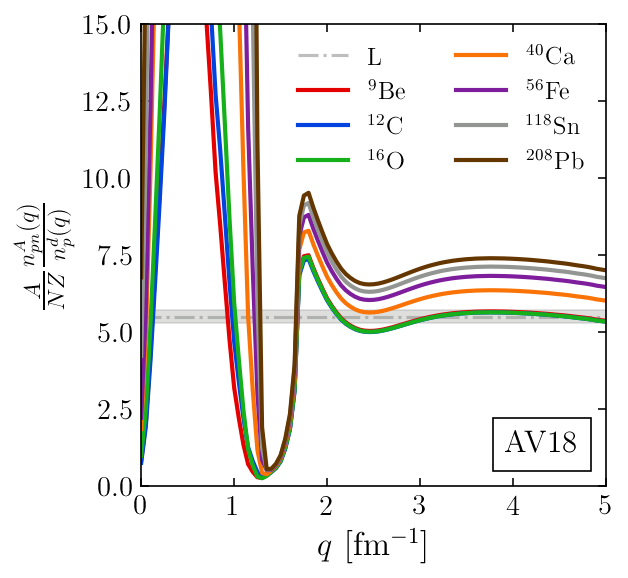

In [13]:
pn_over_d_ratio(nuclei, 6, save=True)

Next, look at the SMS N$^{4}$LO $550$ MeV potential.

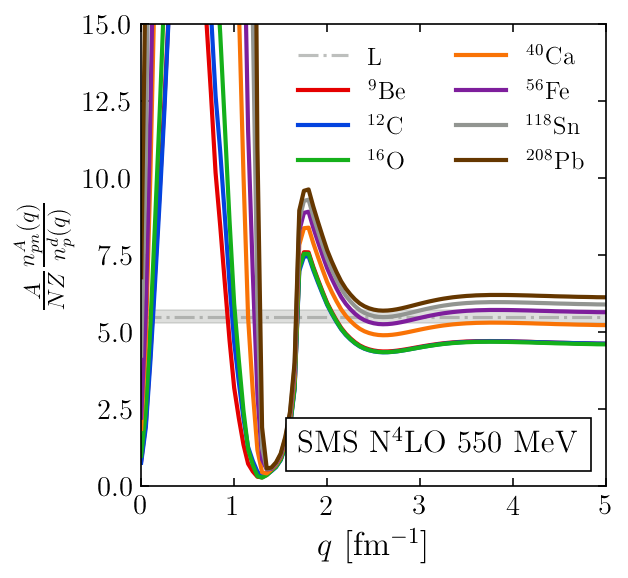

In [14]:
pn_over_d_ratio(nuclei, 113, save=True)

## Levinger constant

In [15]:
nuclei = (
    ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ti48', 22, 26), ('Cu63', 29, 34),
    ('Ag107', 47, 60), ('Sn118', 50, 68), ('Ce140', 58, 82),
    ('Ta181', 73, 108), ('Pb208', 82, 126), ('U238', 92, 146)
)

Average Levinger constant for several nuclei with AV18 comparing to extractions from experiment.

In [16]:
kvnn = 6

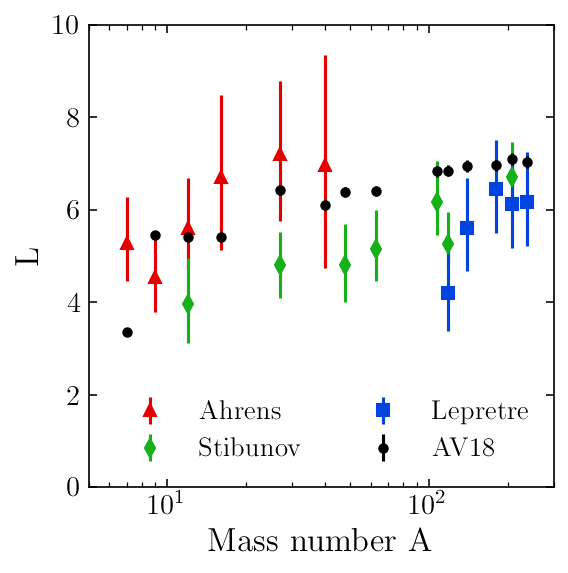

In [17]:
levinger_constant_experiment(nuclei, kvnn, save=True)

Average Levinger constant for several nuclei comparing different NN interactions.

In [18]:
kvnns = (5, 6, 7, 111, 113, 222)

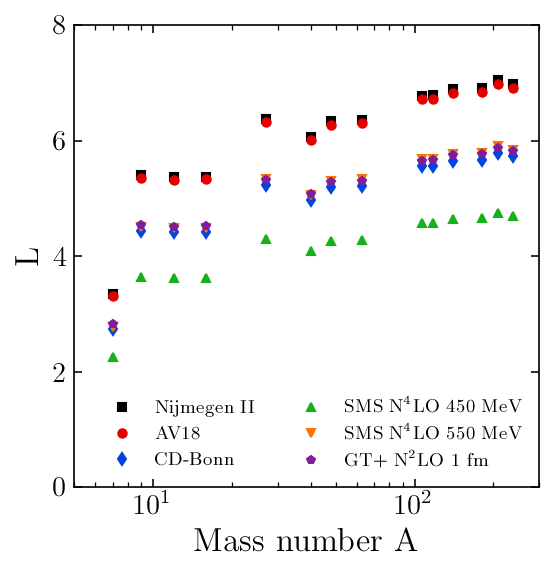

In [19]:
levinger_constant_multiple_kvnns(nuclei, kvnns, save=True)

## Matching deuteron momentum distributions

Deuteron momentum distributions from SMS N$^4$LO $550$ MeV and $450$ MeV potentials.
The dashed lines show the distributions of the $550$ MeV potential but SRG-evolved to some $\lambda$ value indicated by the legend.

In [20]:
kvnn_soft = 111
kvnn_hard = 113
lambdas = (6.0, 4.5, 4.0, 3.5)

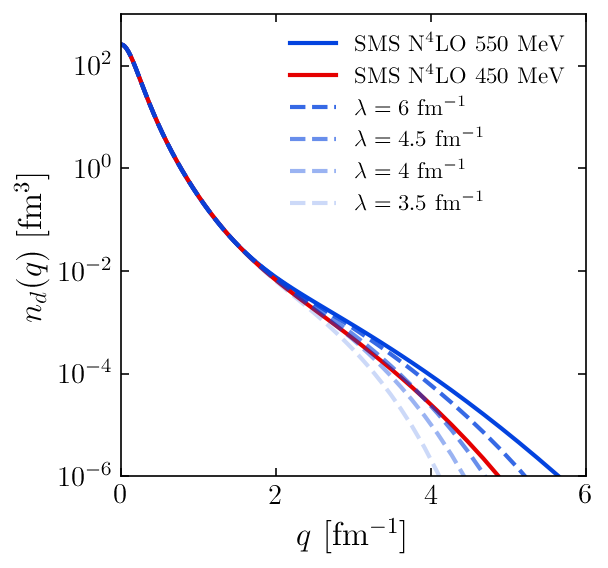

In [21]:
deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambdas, save=True)

Same as the previous figure but comparing AV18 and SMS N$^4$LO $550$ MeV.

In [22]:
kvnn_soft = 113
kvnn_hard = 6
lambdas = (6.0, 5.0, 4.5, 4.0)

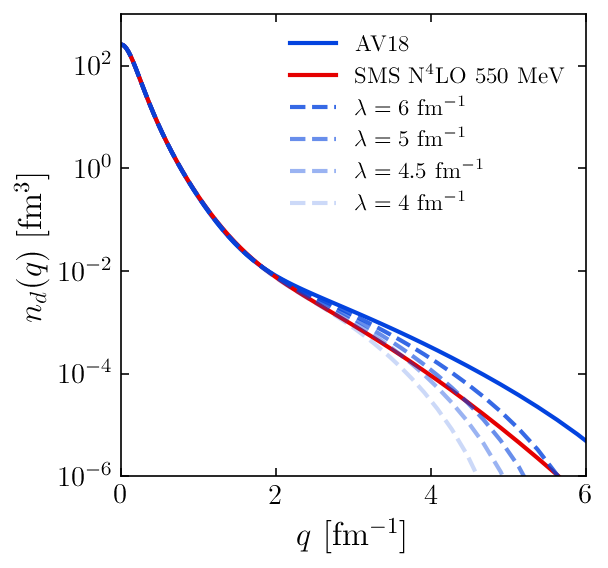

In [23]:
deuteron_scale_dependence(kvnn_soft, kvnn_hard, lambdas, save=True)

## Inverse SRG evolution

Deuteron wave functions of AV18 and SMS N$^4$LO $550$ MeV in coordinate space.
Additionally, we show deuteron wave functions of SMS N$^4$LO $550$ MeV but inverse-SRG transformed with AV18 at several $\lambda_m$ values.
The solid lines correspond to the S states, and the dashed lines correspond to the D states.

In [24]:
kvnn_soft = 113
kvnn_hard = 6
lambda_m_values = (6.0, 5.0, 4.5, 4.0)

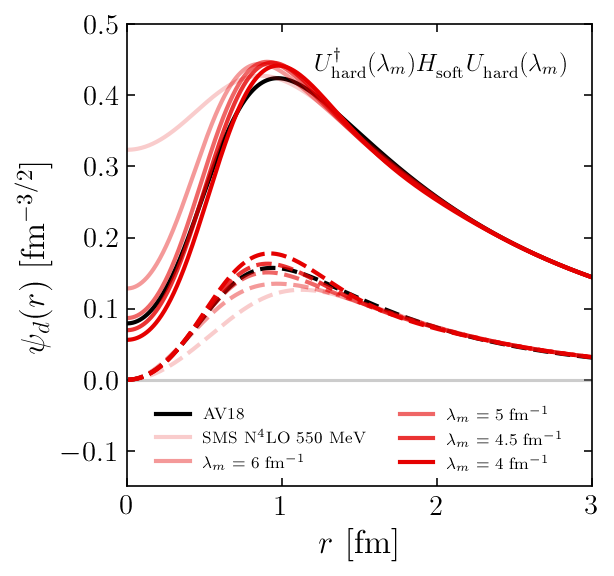

In [25]:
deuteron_scale_dependence_inv_r(kvnn_soft, kvnn_hard, lambda_m_values,
                                save=True)

Same as the previous figure but comparing SMS N$^4$LO $550$ MeV and $450$ MeV potentials.

In [26]:
kvnn_soft = 111
kvnn_hard = 113
lambda_m_values = (6.0, 4.5, 4.0, 3.5)

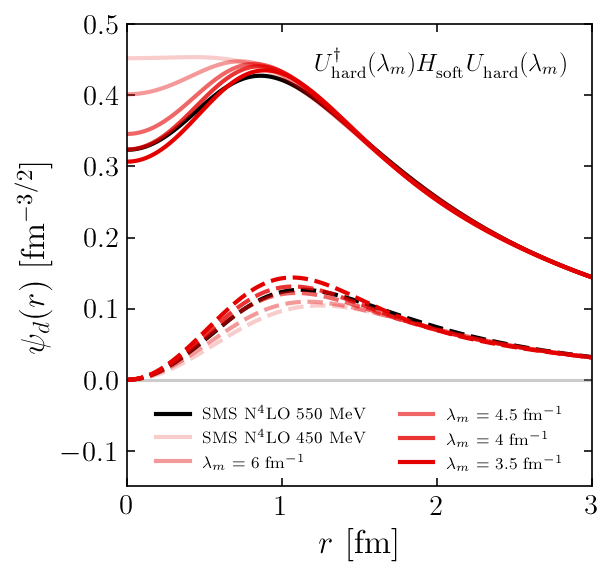

In [27]:
deuteron_scale_dependence_inv_r(kvnn_soft, kvnn_hard, lambda_m_values,
                                save=True)

In [28]:
nuclei = (
    ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ti48', 22, 26), ('Cu63', 29, 34),
    ('Ag107', 47, 60), ('Sn118', 50, 68), ('Ce140', 58, 82),
    ('Ta181', 73, 108), ('Pb208', 82, 126), ('U238', 92, 146)
)

Average Levinger constant for several nuclei comparing the SMS N$^4$LO $550$ MeV and $450$ MeV potentials.
Results are also shown for the SMS N$^4$LO $450$ MeV potential with an additional two-body operator due to inverse-SRG transformations from SMS N$^4$LO $550$ MeV at several values of $\lambda_m$.

In [29]:
kvnn_soft = 111
kvnn_hard = 113
lambda_m_values = (6.0, 4.5, 4.0, 3.5)
y_limits = (0, 7)

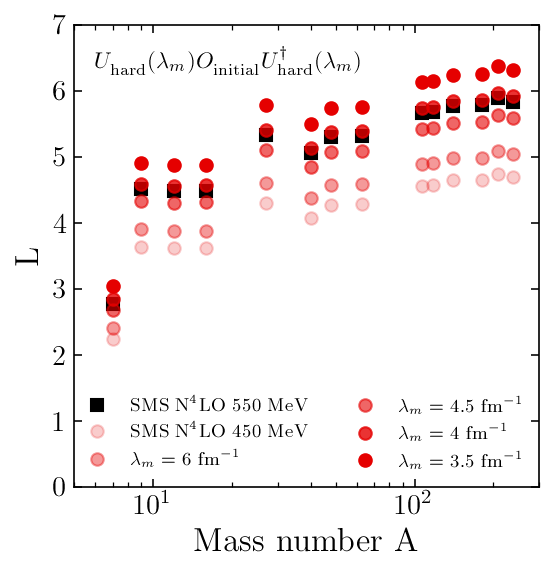

In [30]:
levinger_constant_inverse_srg(nuclei, kvnn_soft, kvnn_hard, lambda_m_values,
                              y_limits=y_limits, save=True)

Same as the previous figure but comparing AV18 and SMS N$^4$LO $550$ MeV.

In [31]:
kvnn_soft = 113
kvnn_hard = 6
lambda_m_values = (6.0, 5.0, 4.5, 4.0)
y_limits = (0, 8)

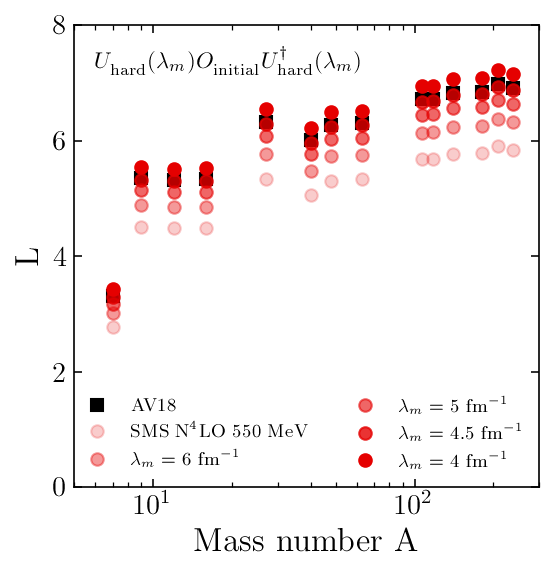

In [32]:
levinger_constant_inverse_srg(nuclei, kvnn_soft, kvnn_hard, lambda_m_values,
                              y_limits=y_limits, save=True)